In [1]:
using LIBSVM
using GLM
using RDatasets
using Gadfly

INFO: Precompiling module LIBSVM.
INFO: Precompiling module GLM.
INFO: Precompiling module RDatasets.
INFO: Precompiling module Gadfly.


In [2]:
#Linear regression
form = dataset("datasets", "Formaldehyde")

,Carb,OptDen
1,0.1,0.086
2,0.3,0.269
3,0.5,0.446
4,0.6,0.538
5,0.7,0.626
6,0.9,0.782


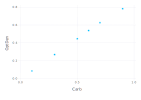

In [3]:
#先看資料分布
plot(form, x=:Carb, y=:OptDen, Geom.point)

In [4]:
#Training model
#formula後面接y和x，若很多個x,x1+x2....
glm = fit(LinearModel, @formula(OptDen ~ Carb), form)

StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: OptDen ~ 1 + Carb

Coefficients:
               Estimate  Std.Error  t value Pr(>|t|)
(Intercept)  0.00508571 0.00783368 0.649211   0.5516
Carb           0.876286  0.0135345  64.7444    <1e-6


In [5]:
#Constructing model
b, m = coef(glm)

2-element Array{Float64,1}:
 0.00508571
 0.876286  

In [6]:
f = x -> m*x + b

(::#1) (generic function with 1 method)

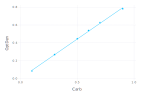

In [7]:
#Visualize
layer1 = layer(form, x=:Carb, y=:OptDen, Geom.point)
layer2 = layer(f, minimum(form[:Carb]), maximum(form[:Carb]))
plot(layer1, layer2)

In [8]:
#Classification
iris = dataset("datasets", "iris")
head(iris, 10)

INFO: Precompiling module RData.


,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa
10,4.9,3.1,1.5,0.1,setosa


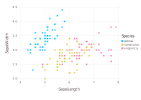

In [9]:
#先看資料分布
plot(iris, x=:SepalLength, y=:SepalWidth, color=:Species, Geom.point)

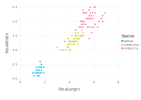

In [10]:
plot(iris, x=:PetalLength, y=:PetalWidth, color=:Species, Geom.point)

In [11]:
labels = convert(Vector, iris[:Species])
instances = convert(Array, iris[:, 1:4])'

4×150 Array{Float64,2}:
 5.1  4.9  4.7  4.6  5.0  5.4  4.6  5.0  …  6.8  6.7  6.7  6.3  6.5  6.2  5.9
 3.5  3.0  3.2  3.1  3.6  3.9  3.4  3.4     3.2  3.3  3.0  2.5  3.0  3.4  3.0
 1.4  1.4  1.3  1.5  1.4  1.7  1.4  1.5     5.9  5.7  5.2  5.0  5.2  5.4  5.1
 0.2  0.2  0.2  0.2  0.2  0.4  0.3  0.2     2.3  2.5  2.3  1.9  2.0  2.3  1.8

In [12]:
#Train SVM on half of the data
model = svmtrain(instances[:, 1:2:end], labels[1:2:end], kernel=Kernel.Linear);

In [13]:
#Prediction
(predicted_labels, decision_values) = svmpredict(model, instances[:, 2:2:end]);

In [14]:
#Accuracy
accuracy = mean((predicted_labels .== labels[2:2:end]))
println("Accuracy: $(accuracy*100)")

Accuracy: 97.33333333333334


In [16]:
testdata = convert(DataFrame, instances[:, 2:2:end]')
rename!(testdata, :x1 => :SepalLength, :x2 => :SepalWidth, :x3 => :PetalLength, :x4 => :PetalWidth)
testdata[:Species] = labels[2:2:end];

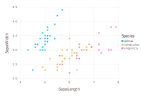

In [17]:
#Ground truth
plot(testdata, x=:SepalLength, y=:SepalWidth, color=:Species, Geom.point)

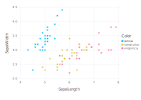

In [18]:
#Predicted
plot(testdata, x=:SepalLength, y=:SepalWidth, color=predicted_labels, Geom.point)

In [19]:
#Dimensional reduction
using MultivariateStats

INFO: Precompiling module MultivariateStats.


In [20]:
#PCA
matrix = convert(Matrix, iris[1:4])
pca = fit(PCA, matrix'; maxoutdim=2) #'代表轉置，maxoutdim要降成幾維

PCA(indim = 4, outdim = 2, principalratio = 0.97769)

In [21]:
#Transform matrix
pc = MultivariateStats.transform(pca, matrix')';

In [22]:
#Visualize
pc = convert(DataFrame, pc)
rename!(pc, :x1 => :PC1, :x2 => :PC2)
pc[:Species] = labels;

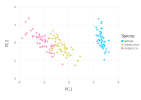

In [23]:
plot(pc, x=:PC1, y=:PC2, color=:Species, Geom.point)